In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import corner
from jnkepler.jaxttv import *
from jnkepler.jaxttv.utils import elements_to_pdic, params_to_elements
from jax.config import config
import numpyro, jax
config.update('jax_enable_x64', True)
numpyro.set_platform('cpu')
num_chains = 4
numpyro.set_host_device_count(num_chains)
print ('# jax device count:', jax.local_device_count())

# jax device count: 4


In [2]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
plt.rcParams["figure.figsize"] = (12,6)
from matplotlib import rc
rc('text', usetex=True)

### define tcobs, errorobs, p_init
- lists of length = (# of planets)
- elements of tcobs and errorobs: arrays of transit times and errors for each planet
- elements of p_init: (reasonably) good guesses for planets' mean periods

In [3]:
d = pd.read_csv("kep51/ttv.txt", delim_whitespace=True, header=None, names=['tnum', 'tc', 'tcerr', 'dnum', 'planum'])
tcobs = [jnp.array(d.tc[d.planum==j+1]) for j in range(3)]
errorobs = [jnp.array(d.tcerr[d.planum==j+1]) for j in range(3)]
p_init = [45.155305, 85.31646, 130.17809]

### define timestep dt, start/end times of integration

In [4]:
dt = 1.0
t_start, t_end = 155., 2950.
jttv = JaxTTV(t_start, t_end, dt) # jaxttv class

### set observed transit times and errors (necessary to obtain model transit times)

In [5]:
jttv.set_tcobs(tcobs, p_init, errorobs=errorobs, print_info=True)

# integration starts at:           155.00
# first transit time in data:      159.11
# last transit time in data:       2945.75
# integration ends at:             2950.00
# integration time step:           1.0000 (1/45 of innermost period)


### least-squares fit for initializing HMC
- defaults to LM optimization with scipy.optimize.curve_fit
- if a good guess is not found, turning on amoeba may help
- this implements only a very simple optimization; one could write a more ellaborate one if necessary

initial objective function: 5448.23 (53 data)

running optimization...
objective function: 50.21 (53 data)
# elapsed time (least square): 1.3 sec


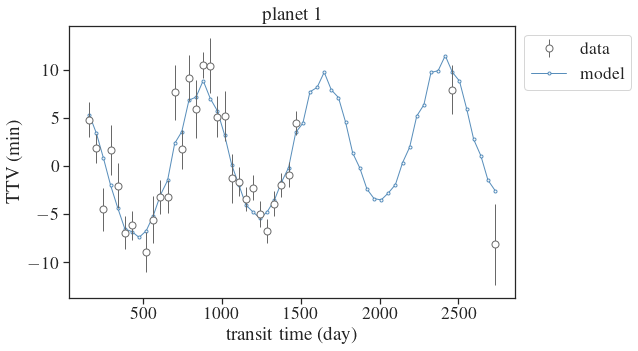

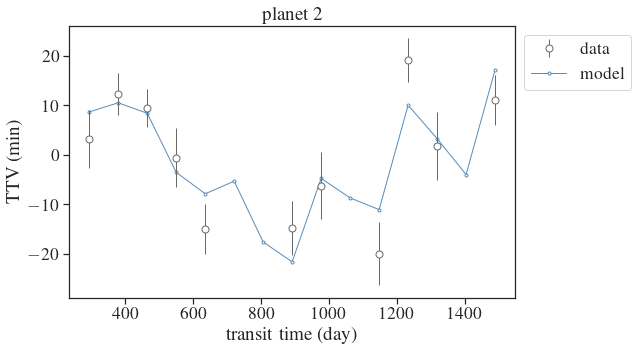

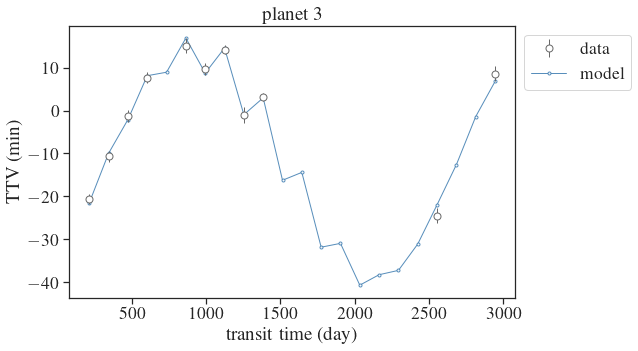

In [6]:
params_best = jttv.optim(mmax=1e-4, emax=0.1)

### show the 'best-fit' parameters found

In [7]:
elements, masses = params_to_elements(params_best, jttv.nplanet)
pdic = pd.DataFrame(elements_to_pdic(elements, masses))
print (pdic)

      pmass      period     ecosw     esinw  cosi  lnode         tic  \
0  2.571991   45.154003 -0.021177 -0.029450   0.0   -0.0  159.110553   
1  4.054968   85.314028  0.015834 -0.004341   0.0   -0.0  295.320951   
2  5.228739  130.183979  0.009119 -0.003446   0.0    0.0  212.023436   

        ecc     omega     lnmass      mass      cosw      sinw  
0  0.036274 -2.194223 -11.771055  0.000008 -0.583821 -0.811883  
1  0.016418 -0.267559 -11.315793  0.000012  0.964419 -0.264378  
2  0.009749 -0.361254 -11.061566  0.000016  0.911929 -0.344559  


### check precision of transit times

In [8]:
# using hermite integrator
tc, tc_precise = jttv.check_timing_precision(params_best)

# fractional energy error (symplectic, dt=1.00e+00): 3.16e-09
# fractional energy error (Hermite4, dt=4.52e-02): -5.20e-12
# max difference in tc: 6.01e-06 days (0.52 sec)


In [9]:
# using symplectic integrator
_, tc_precise_sym = jttv.check_timing_precision(params_best, symplectic=True)

# fractional energy error (symplectic, dt=1.00e+00): 3.16e-09
# fractional energy error (symplectic, dt=4.52e-02): 6.45e-12
# max difference in tc: 6.11e-06 days (0.53 sec)


### check the distribution of residuals

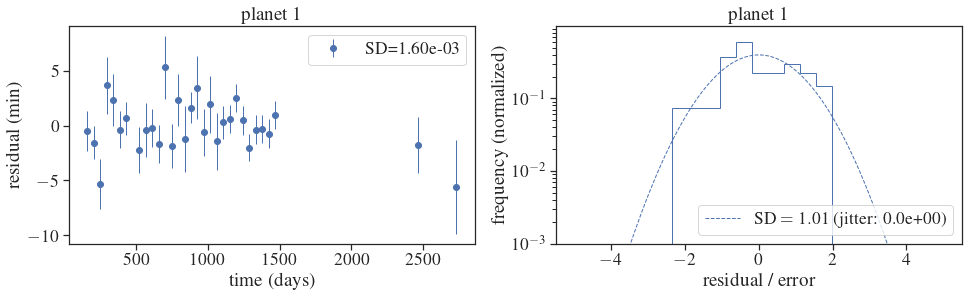

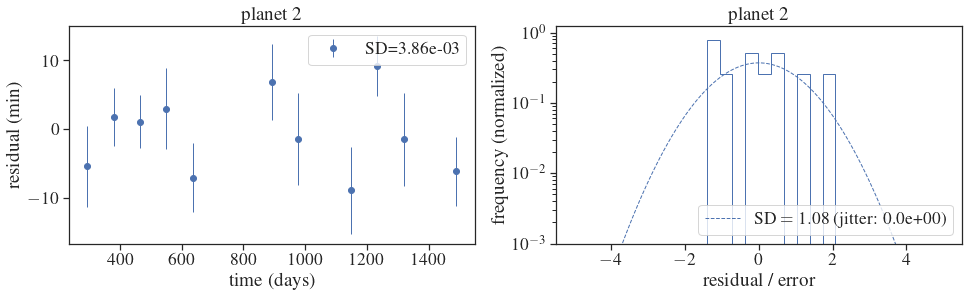

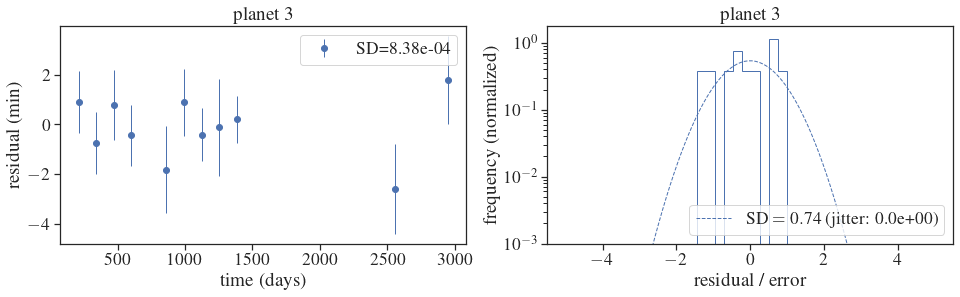

In [10]:
jttv.check_residuals(tc)

### see how long it takes to compute model and gradient

In [11]:
from jax import grad, jit
func = lambda elements, masses: jnp.sum(jttv.get_ttvs(elements, masses)[0])
gfunc = jit(grad(func, argnums=(0,1,))) # gradient

In [40]:
%timeit jttv.get_ttvs(elements, masses)

2.2 ms ± 33.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
%timeit gfunc(elements, masses)

16.7 ms ± 383 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### setup and run HMC
- pdic_init: dict containing best-fit values
- tic_guess: used to set priors for times of inferior conjunction
- p_guess: used to set priors for osculating periods

In [14]:
from numpyro.infer import init_to_value
import numpyro.distributions as dist
import jax.random as random

tic_guess = jnp.array([_tcobs[0] for _tcobs in jttv.tcobs])
p_guess = jnp.array(jttv.p_init)
ones = jnp.ones_like(p_guess)

def model(dp=5e-1, dtic=1e-1, emax=0.3, mmin=1e-7, mmax=1e-3, uniform_mass=False, tcjitter=None):
    tic = numpyro.sample("tic", dist.Uniform(low=tic_guess-dtic, high=tic_guess+dtic))
    period = numpyro.sample("period", dist.Uniform(low=p_guess-dp, high=p_guess+dp))
    ecc = numpyro.sample("ecc", dist.Uniform(low=ones*0, high=ones*emax))
    cosw = numpyro.sample("cosw", dist.Normal(scale=ones))
    sinw = numpyro.sample("sinw", dist.Normal(scale=ones))
    omega = numpyro.deterministic("omega", jnp.arctan2(sinw, cosw))
    lnode = numpyro.deterministic("lnode", ones*0)
    cosi = numpyro.deterministic("cosi", ones*0)
    
    if uniform_mass:
        mass = numpyro.sample("mass", dist.Uniform(low=ones*mmin, high=ones*mmax))
        numpyro.deterministic("lnmass", jnp.log(mass))
    else:
        lnmass = numpyro.sample("lnmass", dist.Uniform(low=ones*jnp.log(mmin), high=ones*jnp.log(mmax)))
        mass = numpyro.deterministic("mass", jnp.exp(lnmass))

    elements = numpyro.deterministic("elements", jnp.array([period, ecc*jnp.cos(omega), ecc*jnp.sin(omega), cosi, lnode, tic]).T)
    masses = numpyro.deterministic("masses", jnp.hstack([1., mass]))
    tcmodel, ediff = jttv.get_ttvs(elements, masses)
    numpyro.deterministic("ediff", ediff)
    numpyro.deterministic("tcmodel", tcmodel)
    
    # assuming gaussian likelihood (+ common "jitter")
    # other functions like Student's t may be used, especially if the residuals show non-gaussian tails
    if tcjitter is not None:
        lntcjitter = numpyro.sample("lntcjitter", dist.Uniform(low=-10, high=jnp.log(tcjitter)))
        tcjitter = numpyro.deterministic("tcjitter", jnp.exp(lntcjitter))
        tcerrmodel = jnp.sqrt(jttv.errorobs_flatten**2 + tcjitter**2)
    else:
        tcerrmodel = jttv.errorobs_flatten     
    numpyro.sample("obs", dist.Normal(loc=tcmodel, scale=tcerrmodel), obs=jttv.tcobs_flatten)

In [15]:
pdic_init = elements_to_pdic(*params_to_elements(params_best, jttv.nplanet), 
                             outkeys=['period', 'ecc', 'cosw', 'sinw', 'cosi', 'lnode', 'tic', 'lnmass', 'mass'])
init_strategy = init_to_value(values=pdic_init)

In [16]:
pdic_init

{'period': DeviceArray([ 45.15400322,  85.31402842, 130.18397873], dtype=float64),
 'cosi': DeviceArray([0., 0., 0.], dtype=float64),
 'lnode': DeviceArray([-0., -0.,  0.], dtype=float64),
 'tic': DeviceArray([159.11055344, 295.32095114, 212.02343566], dtype=float64),
 'ecc': DeviceArray([0.03627368, 0.01641781, 0.00974852], dtype=float64),
 'lnmass': DeviceArray([-11.77105535, -11.31579311, -11.06156579], dtype=float64),
 'mass': DeviceArray([7.72494892e-06, 1.21790522e-05, 1.57044603e-05], dtype=float64),
 'cosw': DeviceArray([-0.58382059,  0.96441913,  0.9119293 ], dtype=float64),
 'sinw': DeviceArray([-0.8118827 , -0.26437803, -0.34455853], dtype=float64)}

In [17]:
kernel = numpyro.infer.NUTS(model, target_accept_prob=0.95, init_strategy=init_strategy)
#forward_mode_differentiation=True)

In [18]:
nw, ns, linear_mass_prior, tcjitter = 500, 1500, True, None # ~9hr on intel imac

In [19]:
assert num_chains <= jax.local_device_count()
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns, num_chains=num_chains)

In [20]:
output = "kep51/dt%.1f_"%jttv.dt
if not linear_mass_prior:
    output += "logm"
if tcjitter is not None:
    output += "jit"
output += "nw%d_ns%d_"%(nw, ns)
if num_chains > 1:
    output += "c%d_"%num_chains

In [21]:
output

'kep51/dt1.0_nw500_ns1500_c4_'

In [22]:
import os, dill
posterior = output + "mcmc.pkl"
if os.path.exists(posterior):
    print (posterior + " loaded.")
    mcmc = dill.load(open(posterior, 'rb'))
else:
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, mmin=0, mmax=5e-4, uniform_mass=linear_mass_prior, tcjitter=tcjitter)
    with open(output+"mcmc.pkl", "wb") as f:
        dill.dump(mcmc, f)

kep51/dt1.0_nw500_ns1500_c4_mcmc.pkl loaded.


### summary statistics

In [23]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   cosw[0]     -0.70      0.44     -0.63     -1.34     -0.06    316.17      1.00
   cosw[1]      0.58      0.88      0.60     -0.80      2.15    453.99      1.01
   cosw[2]     -0.01      0.95      0.02     -1.59      1.51    351.95      1.02
    ecc[0]      0.03      0.01      0.03      0.01      0.05    182.81      1.02
    ecc[1]      0.01      0.01      0.01      0.00      0.03     76.33      1.02
    ecc[2]      0.01      0.01      0.01      0.00      0.02     76.59      1.03
   mass[0]      0.00      0.00      0.00      0.00      0.00    478.83      1.00
   mass[1]      0.00      0.00      0.00      0.00      0.00    273.25      1.01
   mass[2]      0.00      0.00      0.00      0.00      0.00    465.92      1.01
 period[0]     45.15      0.00     45.15     45.15     45.15    640.67      1.00
 period[1]     85.31      0.00     85.31     85.31     85.32    485.88      1.00
 period[2]    130.18      0

In [24]:
samples = mcmc.get_samples()

### trace plots

In [25]:
M_earth = 3.0034893e-6
samples['pmass'] = samples['mass'] / M_earth

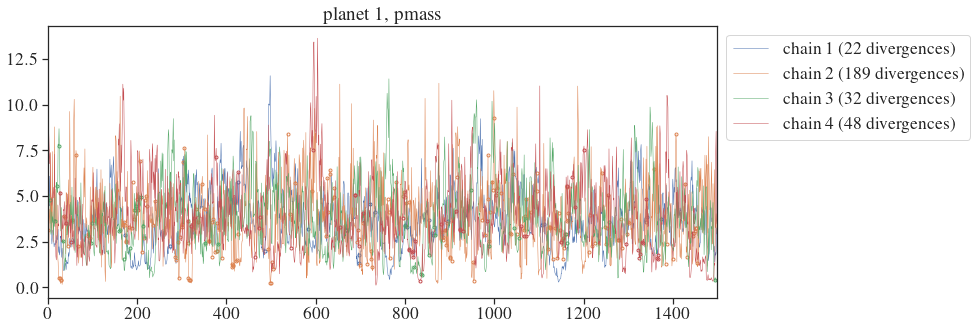

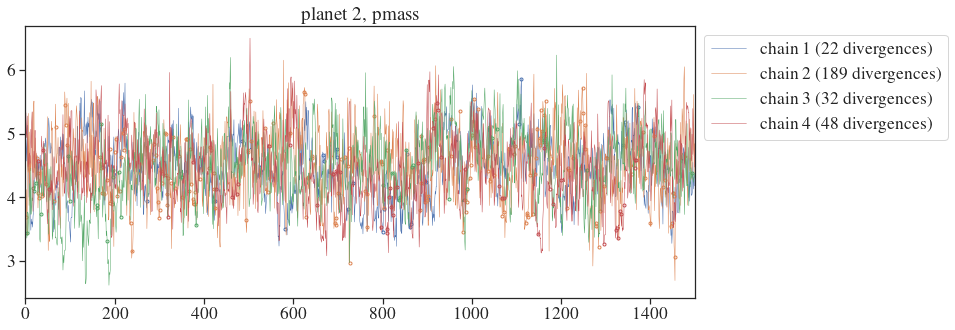

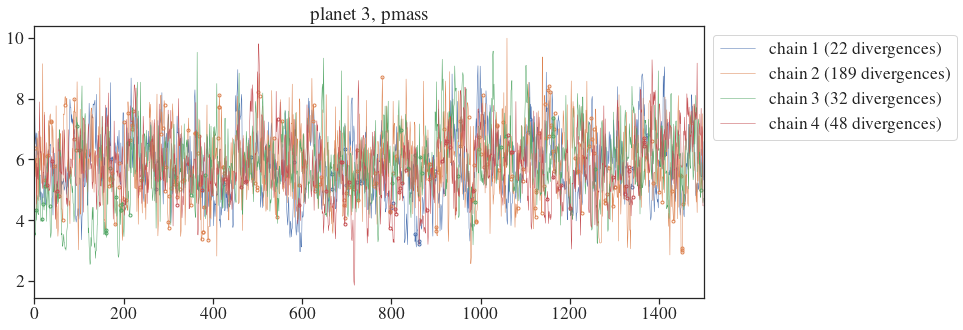

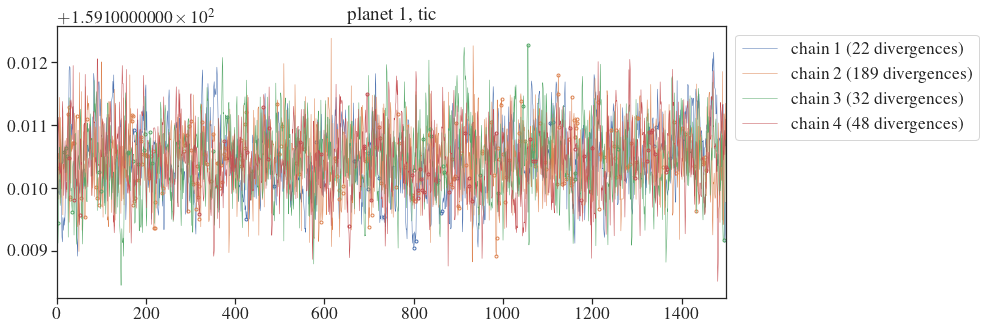

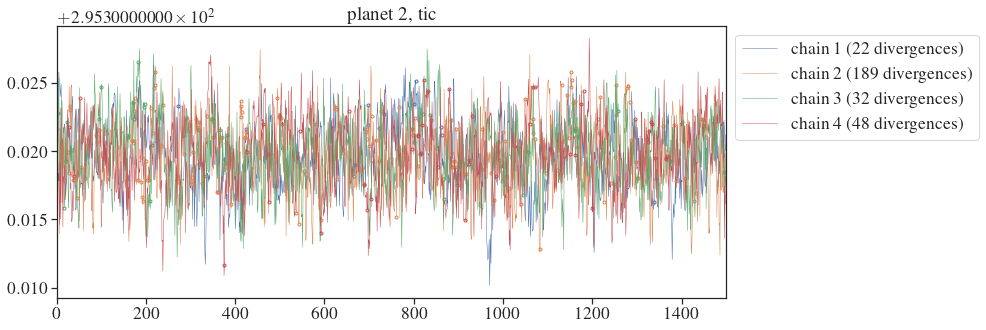

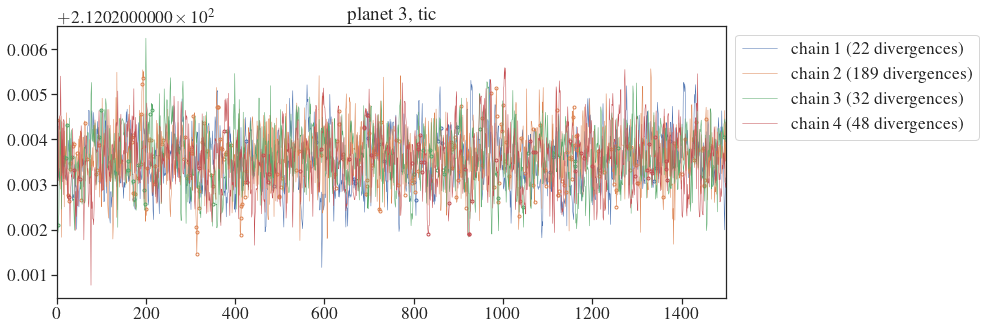

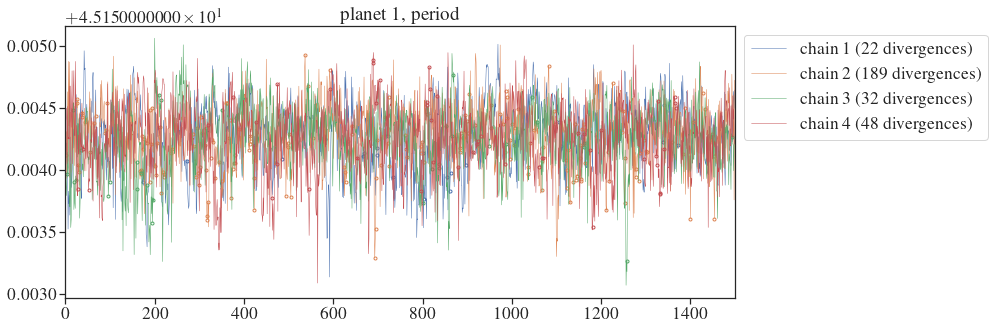

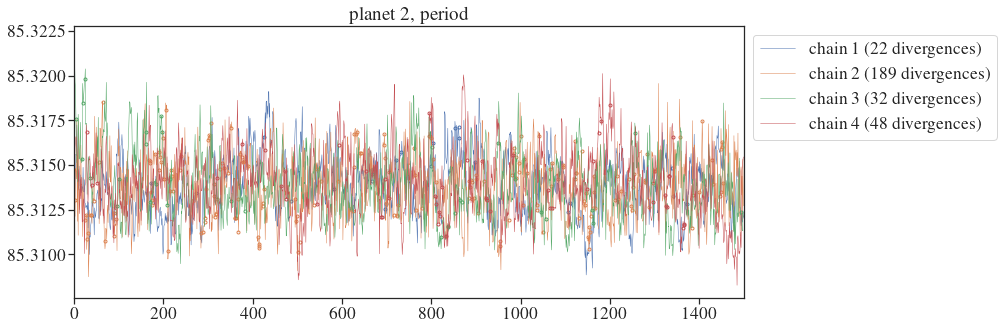

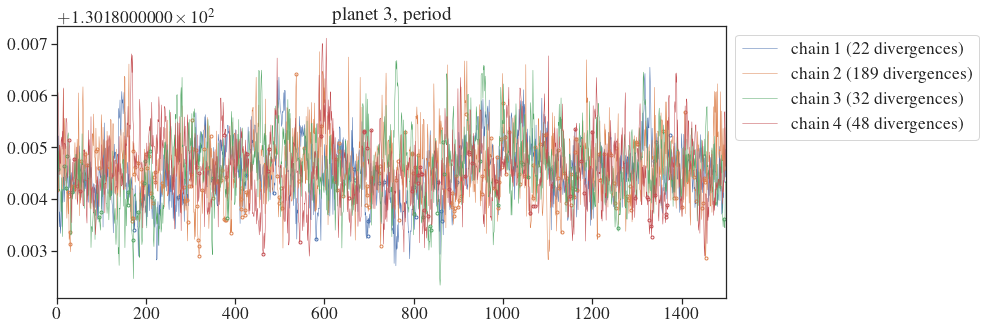

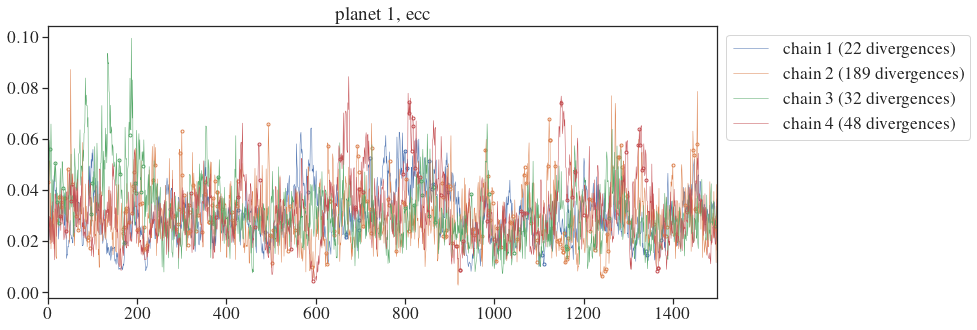

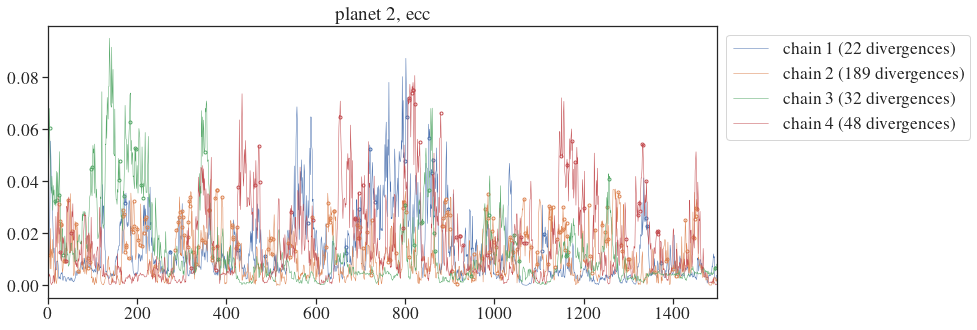

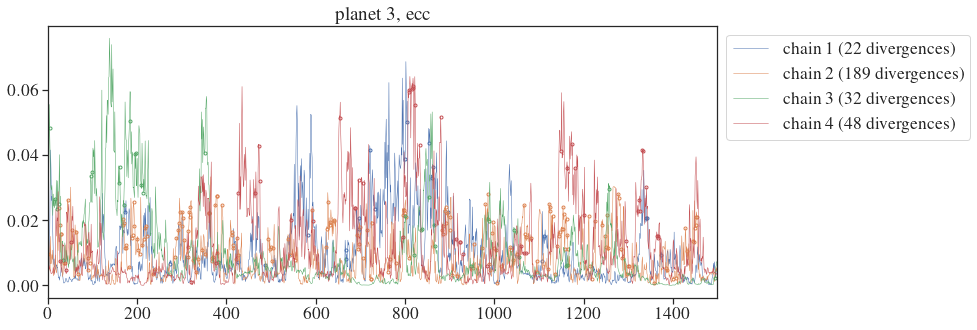

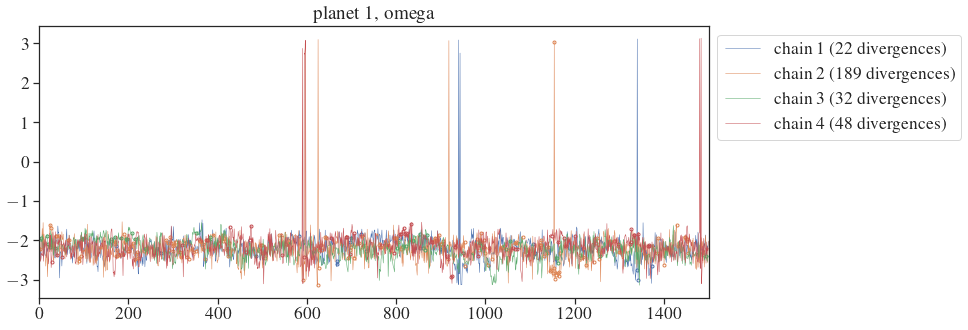

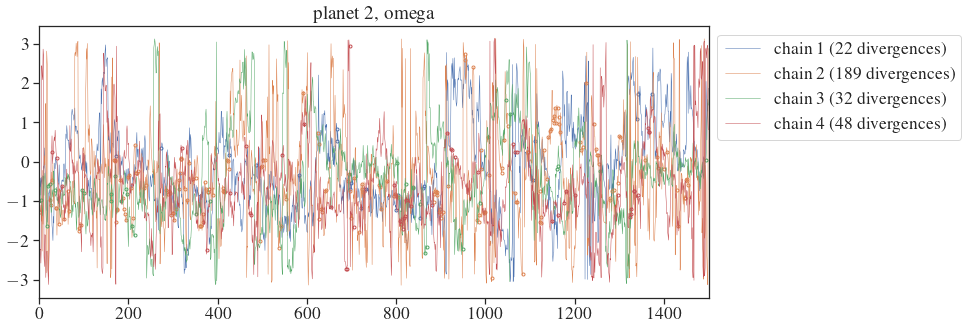

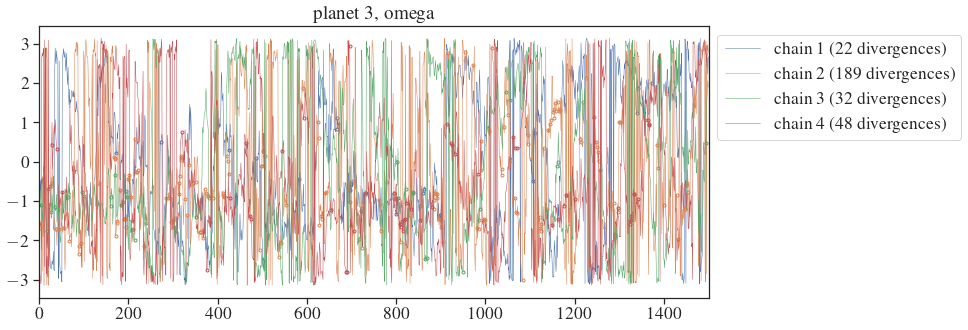

In [26]:
divs = np.array(mcmc.get_extra_fields(group_by_chain=True)['diverging'])
keys = ['pmass', 'tic', 'period', 'ecc', 'omega']
for k in keys:
    if num_chains == 1:
        smp = samples[k][None,:]
    else:
        smp = samples[k].reshape(num_chains,-1,samples[k].shape[1])
    for j in range(jttv.nplanet):
        plt.figure(figsize=(12,5))
        plt.title("planet %d, %s"%((j+1), k))
        plt.xlim(0, np.shape(smp)[1])
        for l in range(num_chains):
            s = smp[l,:,j]
            plt.plot(s, lw=0.5, color='C%d'%l, label='chain %d (%d divergences)'%(l+1, np.sum(divs[l,:])))
            _s = np.array(smp[l,:,j])
            _s[~divs[l,:]]= np.nan
            plt.plot(_s, 'o', mew=1, mfc='none', color='C%d'%l, markersize=3)
        plt.legend(loc='best', bbox_to_anchor=(1,1))

### plot posterior models

In [27]:
means, stds = jttv.sample_means_and_stds(samples)

/Users/k_masuda/.pyenv/versions/anaconda3-5.3.1/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


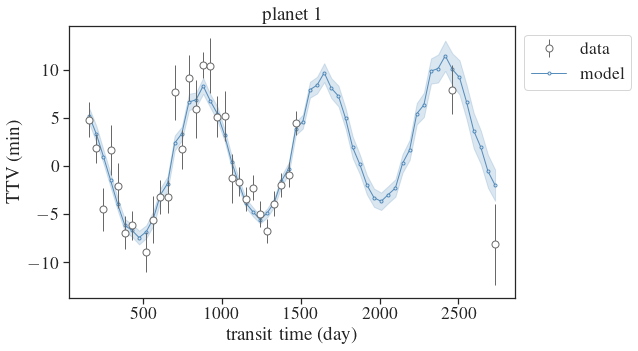

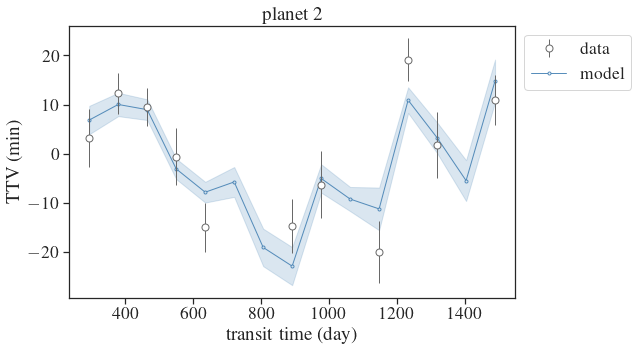

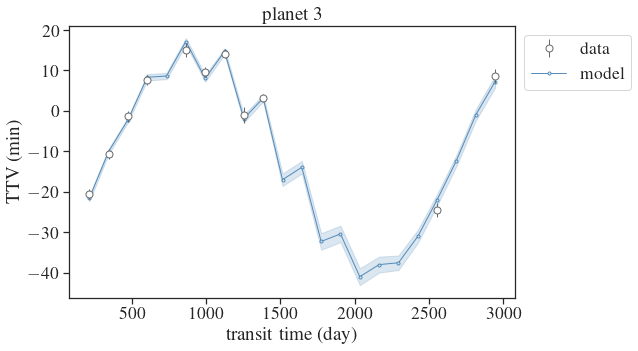

In [28]:
t0_lin, p_lin = jttv.linear_ephemeris()
plot_model(means, jttv.tcobs, jttv.errorobs, t0_lin, p_lin, tcmodelunclist=stds, marker='.')

### corner plots

In [29]:
keys = ['pmass', 'tic', 'period', 'ecc', 'omega']

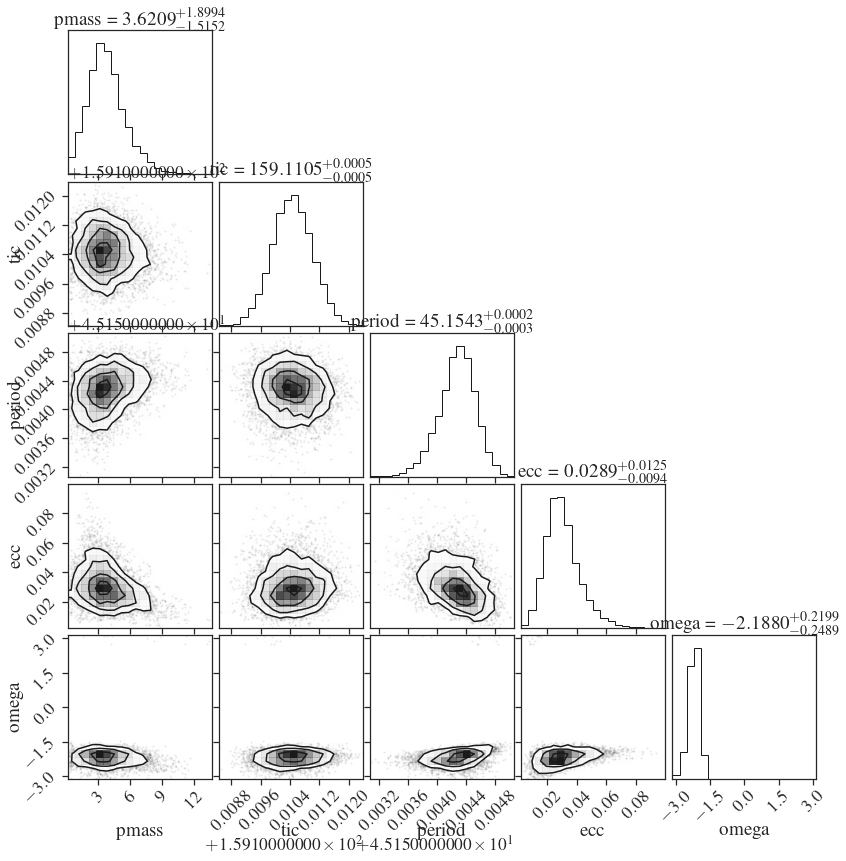

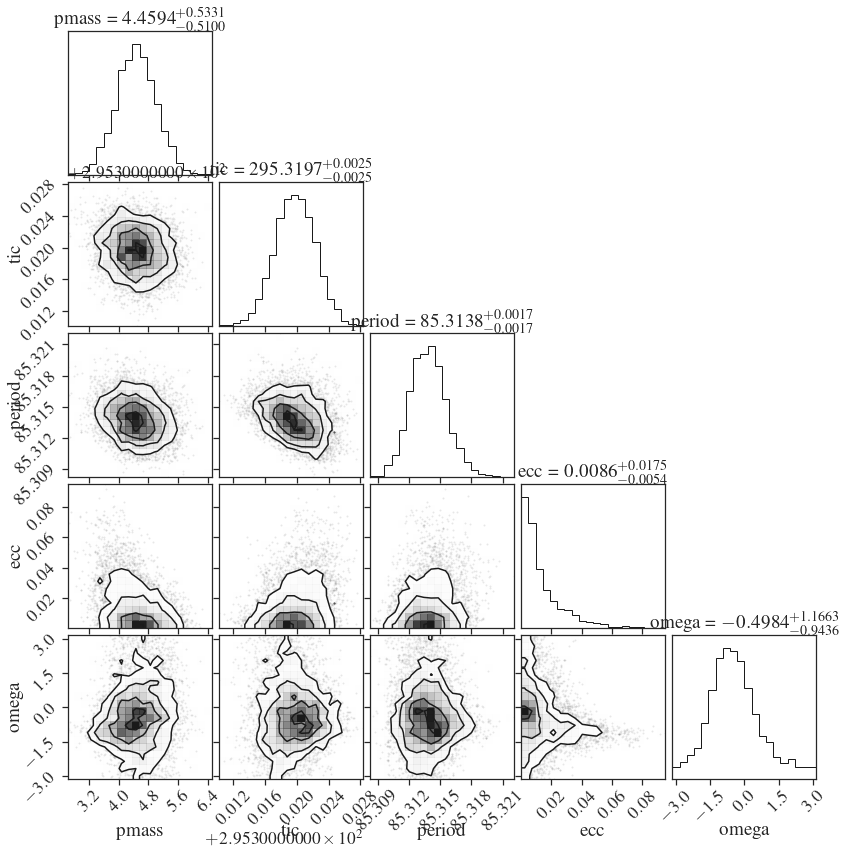

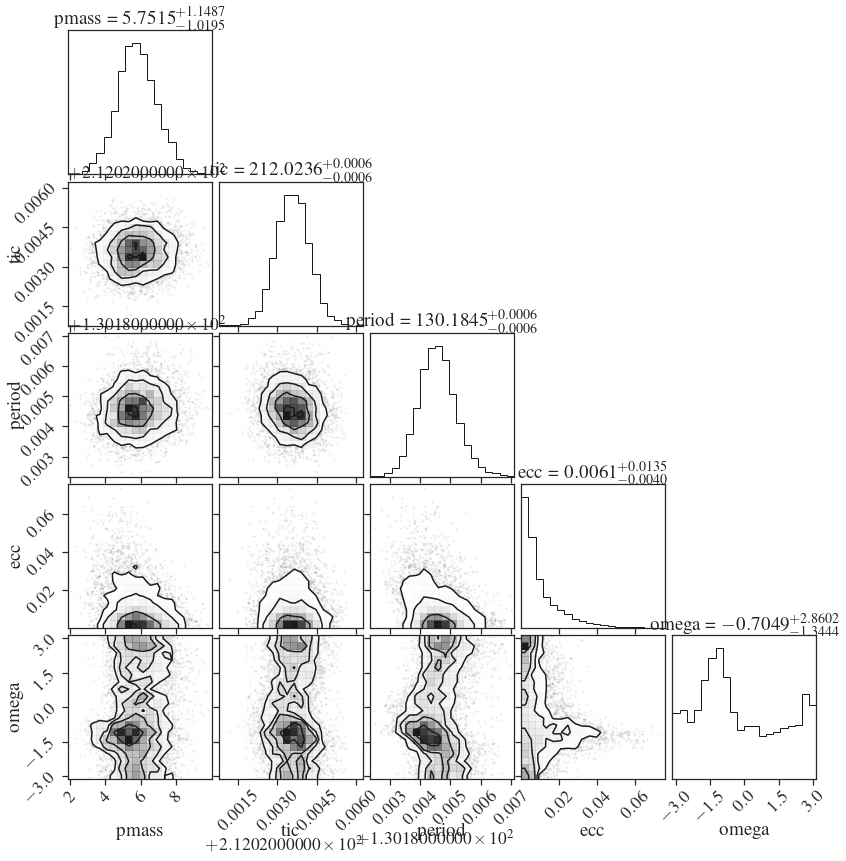

In [30]:
for j in range(jttv.nplanet):
    hyper = pd.DataFrame(data=dict(zip(keys, [samples[k][:,j] for k in keys])))
    if tcjitter is not None:
        hyper['lntcjitter'] = samples['lntcjitter']
        labels = keys + ['lntcjitter']
    else:
        labels = keys
    fig = corner.corner(hyper, labels=labels, show_titles=True, title_fmt=".4f")
    #plt.savefig(output+"corner%d.png"%(j+1), dpi=200, bbox_inches="tight");

### check energy conservation

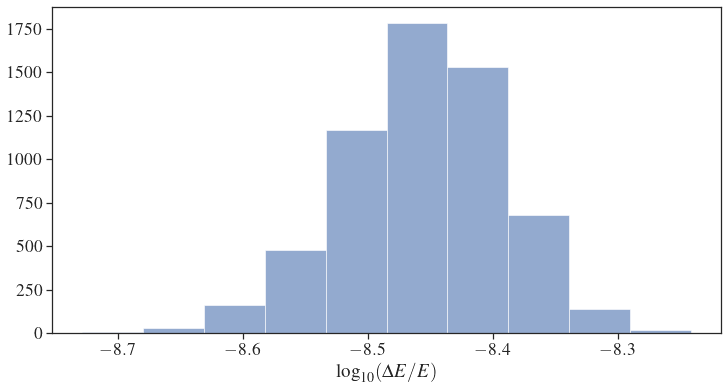

In [31]:
plt.xlabel("$\log_{10} (\Delta E/E)$")
plt.hist(np.log10(np.abs(samples['ediff'])), alpha=0.6);

### TTVFast parameters and models

In [32]:
from jnkepler.jaxttv.ttvfastutils import *
from jnkepler.jaxttv.utils import findidx_map

In [33]:
# dataframe containing parameter sets for TTVFast
pttvfast = params_for_ttvfast(samples, jttv.t_start, jttv.nplanet)

In [34]:
# let's compute mean and std of 50 models
np.random.seed(123)
idxs = np.random.randint(0,len(pttvfast),50)
models_tf, maxdiff_sec = [], []
for idx in idxs:
    _, tcs_tf = get_ttvfast_model(pttvfast.iloc[idx], jttv.nplanet, t_start, dt, t_end)
    models_tf.append(tcs_tf)
    
    tcs_tf_flatten = np.hstack(tcs_tf) 
    tcs_jttv = np.array(samples['tcmodel'][idx])
    diff = tcs_jttv - tcs_tf_flatten[findidx_map(tcs_tf_flatten, tcs_jttv)]
    maxdiff_sec.append(np.max(np.abs(diff))*86400.)

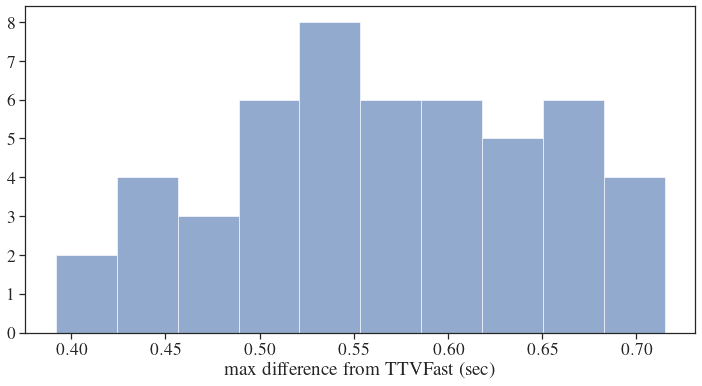

In [35]:
# check agreement with TTVFast
plt.xlabel("max difference from TTVFast (sec)")
plt.hist(maxdiff_sec, alpha=0.6);

In [36]:
means_tf, stds_tf = get_means_and_stds(models_tf)

/Users/k_masuda/.pyenv/versions/anaconda3-5.3.1/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


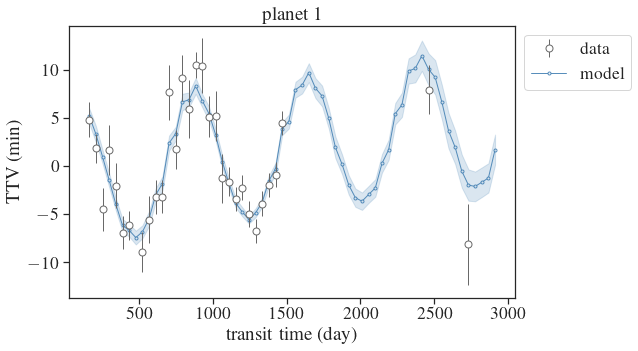

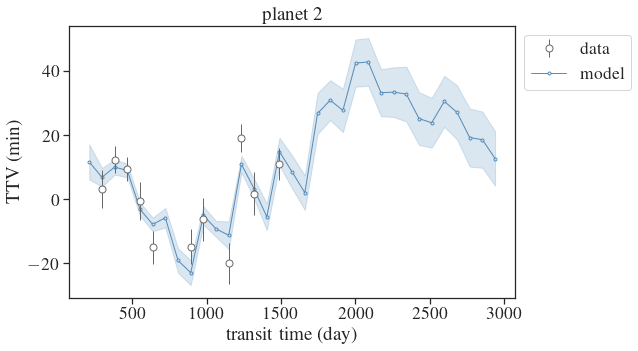

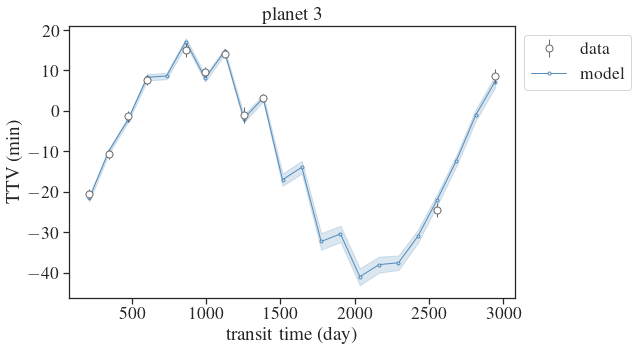

In [37]:
# visualize TTVFast models
plot_model(means_tf, jttv.tcobs, jttv.errorobs, t0_lin, p_lin, tcmodelunclist=stds_tf, marker='.')

In [38]:
# similar dataframe for REBOUND (set WHsplit=False; check if angles should be in degrees or not)
prebound = params_for_ttvfast(samples, jttv.t_start, jttv.nplanet, WHsplit=False, angles_in_degrees=True)

In [39]:
prebound

planet_mass0    period0  eccentricity0  inclination0   argument0  \
0         0.000012  45.154273       0.019415          90.0 -127.394300   
1         0.000012  45.154194       0.020319          90.0 -128.239236   
2         0.000014  45.154218       0.023285          90.0 -128.351474   
3         0.000013  45.154133       0.024624          90.0 -132.370795   
4         0.000018  45.153978       0.022893          90.0 -141.206961   
...            ...        ...            ...           ...         ...   
5995      0.000007  45.154597       0.018785          90.0 -116.785979   
5996      0.000022  45.154408       0.018854          90.0 -134.646884   
5997      0.000026  45.154491       0.020604          90.0 -123.803607   
5998      0.000011  45.154242       0.031390          90.0 -130.007331   
5999      0.000010  45.154207       0.036522          90.0 -125.938427   

         longnode0  mean_anomaly0  planet_mass1    period1  eccentricity1  \
0     7.062250e-31    -174.006818      0.000015  85.311456       0.008709   
1    -3.531125e-31    -173.072884      0.000015  85.312478       0.012514   
2     0.000000e+00    -172.739444      0.000014  85.314165       0.013380   
3     0.000000e+00    -168.470010      0.000014  85.314306       0.011858   
4     0.000000e+00    -159.493453      0.000015  85.315589       0.019700   
...            ...            ...           ...        ...            ...   
5995  0.000000e+00     174.995061      0.000016  85.312178       0.000353   
5996  0.000000e+00    -166.594361      0.000015  85.314708       0.000208   
5997 -7.062250e-31    -177.637552      0.000015  85.314987       0.000218   
5998  0.000000e+00    -170.411494      0.000014  85.315226       0.000510   
5999  3.531125e-31    -174.326308      0.000013  85.315446       0.000439   

      ...  mean_anomaly1  planet_mass2     period2  eccentricity2  \
0     ...    -109.674287      0.000027  130.184098       0.003693   
1     ...    -122.602283      0.000023  130.184390       0.007004   
2     ...    -106.522332      0.000020  130.184406       0.007622   
3     ...    -119.810397      0.000020  130.184215       0.005987   
4     ...     -94.902300      0.000021  130.185218       0.013041   
...   ...            ...           ...         ...            ...   
5995  ...      66.805675      0.000018  130.184723       0.003440   
5996  ...      55.407806      0.000021  130.185617       0.003523   
5997  ...      48.312355      0.000021  130.185686       0.003720   
5998  ...     151.432935      0.000013  130.185029       0.003396   
5999  ...     171.502917      0.000013  130.184629       0.003412   

      inclination2   argument2     longnode2  mean_anomaly2  star_mass  \
0             90.0  -36.415440 -3.531125e-31     -31.616671        1.0   
1             90.0  -19.694647  1.765563e-31     -48.751894        1.0   
2             90.0  -41.976822  0.000000e+00     -26.364443        1.0   
3             90.0  -26.724362  1.765563e-31     -41.579648        1.0   
4             90.0  -54.676387  0.000000e+00     -13.880402        1.0   
...            ...         ...           ...            ...        ...   
5995          90.0  145.415045  3.531125e-31     147.222243        1.0   
5996          90.0  154.976861 -5.296688e-31     137.701861        1.0   
5997          90.0  154.971682 -3.531125e-31     137.728443        1.0   
5998          90.0  158.931021 -5.296688e-31     133.746589        1.0   
5999          90.0  158.875029  0.000000e+00     133.803371        1.0   

      num_planets  
0               3  
1               3  
2               3  
3               3  
4               3  
...           ...  
5995            3  
5996            3  
5997            3  
5998            3  
5999            3  

[6000 rows x 23 columns]